# Data Analysis & Preprocessing

I thought it would be more helpful to process each feature separately, so Exploratory Data Analysis and Data Preprocessing are merged in this notebook.
Data visualization, outlier analysis and feature engineering are also present.

## Table of Contents

1. [Data Loading](#data_loading)
2. [Missing Values Analysis](#missing_values)
3. [Target Analysis](#target_analysis)
4. [Features Analysis](#features)
5. [Target Correlation](#target_correlation)
5. [Final Data Preparation](#data_preparation)

Import libraries and utility functions:

In [218]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer

from utils import nulls_table, to_numeric, outliers

sns.set_style('whitegrid')
sns.set_palette('pastel')

## 1. Data Loading <a id='data_loading'></a>

In [219]:
df_train = pd.read_csv('../data/input/train.csv')
df_test = pd.read_csv('../data/input/test.csv')

df = df_train.copy()
df.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


In [220]:
print('Shape of train data: ', df.shape)
print('Shape of test data: ', df_test.shape)

Shape of train data:  (19158, 14)
Shape of test data:  (2129, 13)


In [221]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int64  
 1   city                    19158 non-null  object 
 2   city_development_index  19158 non-null  float64
 3   gender                  14650 non-null  object 
 4   relevent_experience     19158 non-null  object 
 5   enrolled_university     18772 non-null  object 
 6   education_level         18698 non-null  object 
 7   major_discipline        16345 non-null  object 
 8   experience              19093 non-null  object 
 9   company_size            13220 non-null  object 
 10  company_type            13018 non-null  object 
 11  last_new_job            18735 non-null  object 
 12  training_hours          19158 non-null  int64  
 13  target                  19158 non-null  float64
dtypes: float64(2), int64(2), object(10)
me

Most of the columns are object type. We will need to convert them to numerical type for machine learning in the later stage, but first, I'll drop the columns that are not useful for the analysis.

In [222]:
df.drop('enrollee_id', axis=1, inplace=True)
df_test.drop('enrollee_id', axis=1, inplace=True)

As grammatical errors are found in the column names, I will rename them to make them more readable.

In [223]:
df.rename(columns={'relevent_experience': 'relevant_experience'}, inplace=True)
df_test.rename(columns={'relevent_experience': 'relevant_experience'}, inplace=True)

## 2. Missing Values Analysis <a id='missing_values'></a>

In [224]:
print('Train columns with null values:')
nulls_table(df)

Train columns with null values:


,nulls,%
gender,4508,23.53
enrolled_university,386,2.01
education_level,460,2.40
major_discipline,2813,14.68
experience,65,0.34
company_size,5938,30.99
company_type,6140,32.05
last_new_job,423,2.21


In [225]:
print('Test columns with null values:')
nulls_table(df_test)

Test columns with null values:


,nulls,%
gender,508,23.86
enrolled_university,31,1.46
education_level,52,2.44
major_discipline,312,14.65
experience,5,0.23
company_size,622,29.22
company_type,634,29.78
last_new_job,40,1.88


Around 30% of the data is missing in the company_size and company_type columns, as both seem to be related. Despite not exceeding the 50% threshold, I found that dropping the null values definitely increses the performance of the model, compared to imputing them. (I will do this step later in the notebook)

## 3. Target Analysis <a id='target_analysis'></a>

First, I will check the distribution of the target variable.

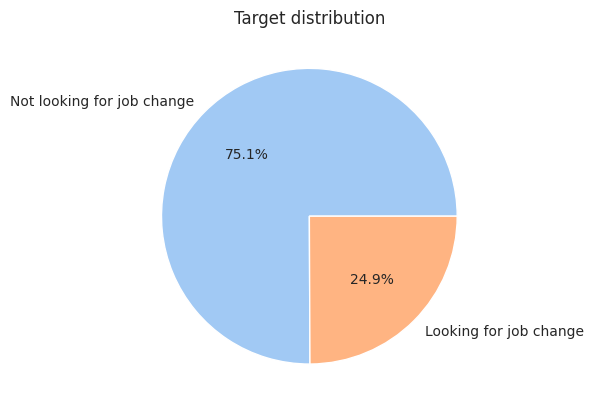

In [226]:
plt.pie(df['target'].value_counts(), labels=['Not looking for job change', 'Looking for job change'], autopct='%1.1f%%')
plt.title('Target distribution')
plt.show()

About 75% of the people in the dataset are not looking for a job change. Thus, the data is unbalanced.

## 4. Features Analysis <a id='features'></a>

### city and city_development_index

The values for the city column are of the form 'city_XXX'. I will remove the 'city_' part and convert the column to numerical type, leaving the identification number only.

In [227]:
df['city'] = df['city'].apply(lambda x: x.split('_')[1]).astype(int)
df_test['city'] = df_test['city'].apply(lambda x: x.split('_')[1]).astype(int)

df.rename(columns={'city': 'city_id'}, inplace=True)
df_test.rename(columns={'city': 'city_id'}, inplace=True)

df.head()

,city_id,city_development_index,gender,relevant_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


In [228]:
print('Number of cities: ', df['city_id'].nunique())
print('Number of city_development_index: ', df['city_development_index'].nunique())

Number of cities:  123
Number of city_development_index:  93


We can visualize the distribution of the most common cities in a bar plot.

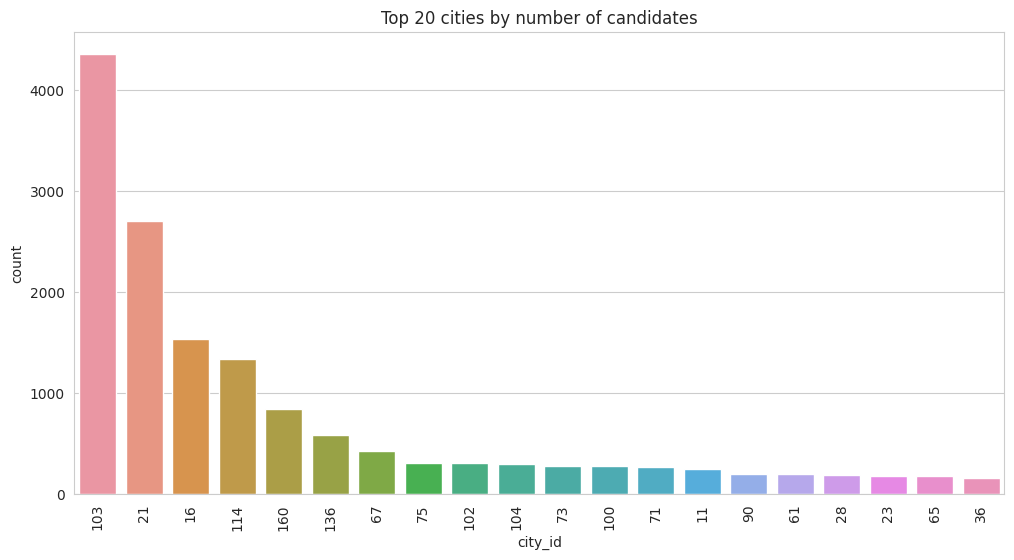

In [229]:
top_cities = df['city_id'].value_counts().head(20).index

plt.figure(figsize=(12, 6))
sns.countplot(x='city_id', data=df, order=top_cities)
plt.xticks(rotation=90)
plt.title('Top 20 cities by number of candidates')
plt.show()

It is clear that the city with the id of 103 is the most common one, followed by the city with the id of 21.

In [230]:
df['city_development_index'].describe()

count    19158.000000
mean         0.828848
std          0.123362
min          0.448000
25%          0.740000
50%          0.903000
75%          0.920000
max          0.949000
Name: city_development_index, dtype: float64

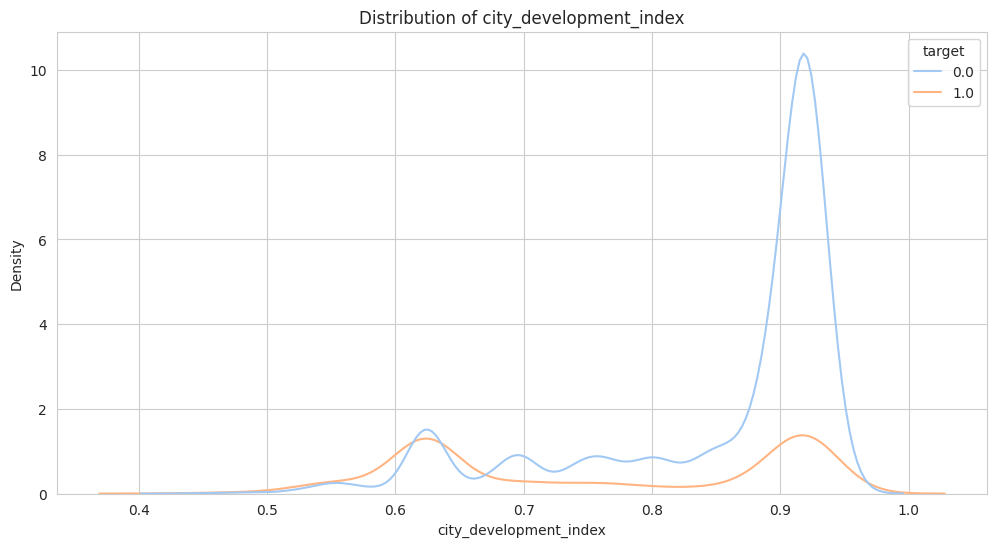

In [231]:
plt.figure(figsize=(12, 6))
sns.kdeplot(data=df, x='city_development_index', hue=df['target'])
plt.title('Distribution of city_development_index')
plt.show()

Most candidates originate from cities with higher development index.

Furthermore, it seems that higher values reduce the likelihood of job change, since it may indicate a more stable job market. Thus, it is an important feature.

Proceeding with outliers.

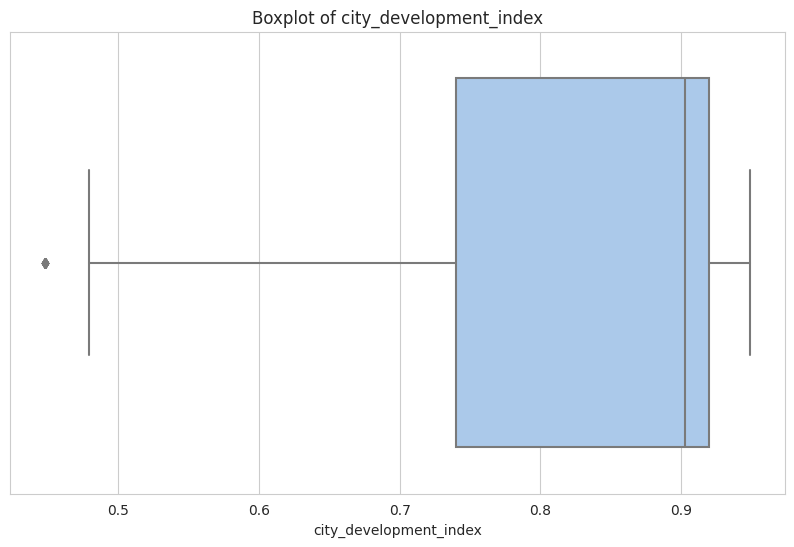

Number of outliers:  17


In [232]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['city_development_index'])
plt.title('Boxplot of city_development_index')
plt.show()

city_dev_outliers = outliers(df, 'city_development_index')
print('Number of outliers: ', len(city_dev_outliers))

In [233]:
city_dev_outliers[['city_id', 'city_development_index']]

,city_id,city_development_index
1523,33,0.448
4744,33,0.448
5010,33,0.448
5265,33,0.448
5567,33,0.448
6127,33,0.448
7724,33,0.448
7864,33,0.448
9134,33,0.448
10401,33,0.448


All outliers have the value for city_development_index = 0.448 coresponding to city 33. This seems reasonable, since the city with the id of 33 has the lowest development index. 

### gender

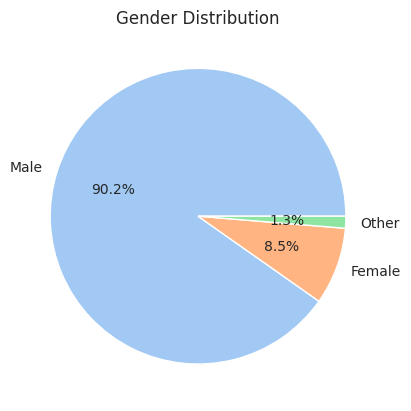

In [234]:
plt.pie(df['gender'].value_counts(), autopct='%1.1f%%', labels=['Male', 'Female', 'Other'])
plt.title('Gender Distribution')
plt.show()

In [235]:
print('Ratios of target per gender:')
print(df.groupby('gender')['target'].sum() / df.groupby('gender')['target'].count())

Ratios of target per gender:
gender
Female    0.263328
Male      0.227819
Other     0.261780
Name: target, dtype: float64


As expected in STEM fields, men outnumber women by far in the dataset.

However, it seems that there is no significant discrepency between the likelihood of job change between genders based on percentages.

The missing values will be imputed with 'Unknown', as they are 23% of the total. Since only four values are for the variable gender, I will convert to numeric type.

In [236]:
df['gender'].fillna('Unknown', inplace=True)
df_test['gender'].fillna('Unknown', inplace=True)

df = to_numeric(df, 'gender')
df_test = to_numeric(df_test, 'gender')

df.head()

,city_id,city_development_index,gender,relevant_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,103,0.920,1,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,40,0.776,1,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,21,0.624,3,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,115,0.789,3,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,162,0.767,1,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


### relevant_experience and experience

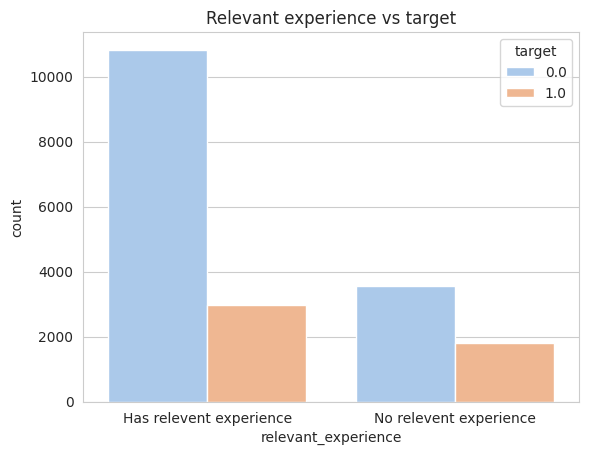

In [237]:
sns.countplot(x='relevant_experience', hue='target', data=df)
plt.title('Relevant experience vs target')
plt.show()

People with relevant experience outnumber those without it. Among them, the proportion of individuals who choose to stay in their company is significantly higher compared to those who do not have relevant experience.

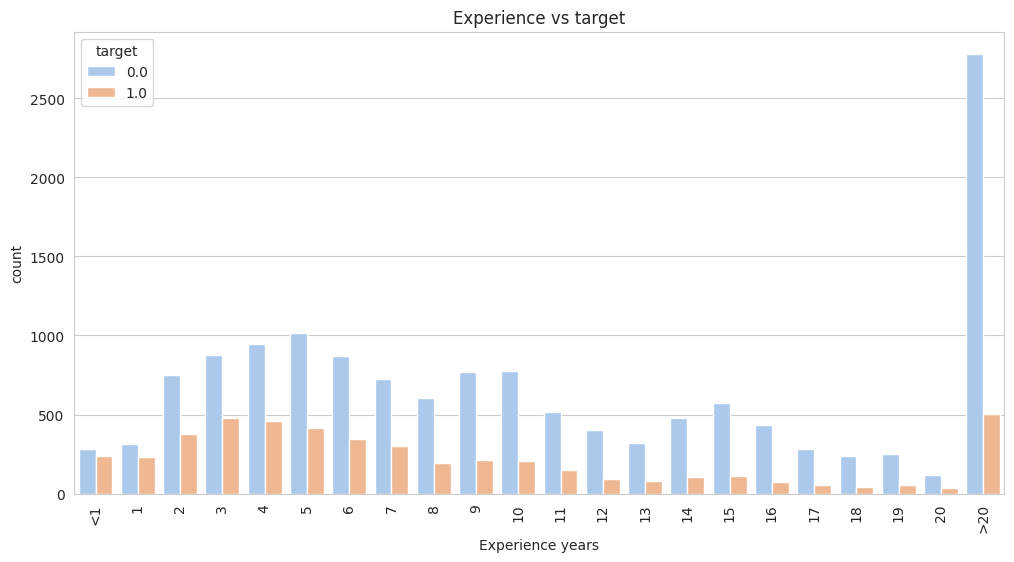

In [238]:
sorted_exp = ['<1'] + [str(i) for i in range(1, 21)] + ['>20']

plt.figure(figsize=(12, 6))
sns.countplot(x='experience', hue='target', data=df, order=sorted_exp)
plt.xticks(rotation=90)
plt.title('Experience vs target')
plt.xlabel('Experience years')
plt.show()

Most of the people in the dataset have 20+ years of experience.

In [239]:
print('Ratio of people looking for job change per experience level:')
ratios = df.groupby('experience')['target'].sum() / df.groupby('experience')['target'].count()
print(ratios.sort_values(ascending=False).head(10))

Ratio of people looking for job change per experience level:
experience
<1    0.454023
1     0.424408
3     0.353028
2     0.331854
4     0.325731
7     0.294747
5     0.288112
6     0.282072
8     0.243142
11    0.227410
Name: target, dtype: float64


Based on the ratios, people with 0-4 years of experience are more likely to look for a job change.

To deal with values like '>20', '<1', I will convert them to numerical type. Since the experience column has null values, I will impute them with the median and will explore the relationship of the experience column with relevant_experience.

In [240]:
df['experience'].replace({'>20': 21, '<1': 0}, inplace=True)
df_test['experience'].replace({'>20': 21, '<1': 0}, inplace=True)

In [241]:
imputer = KNNImputer(n_neighbors=5)

df['experience'] = imputer.fit_transform(df[['experience']]).astype(int)
df_test['experience'] = imputer.transform(df_test[['experience']]).astype(int)

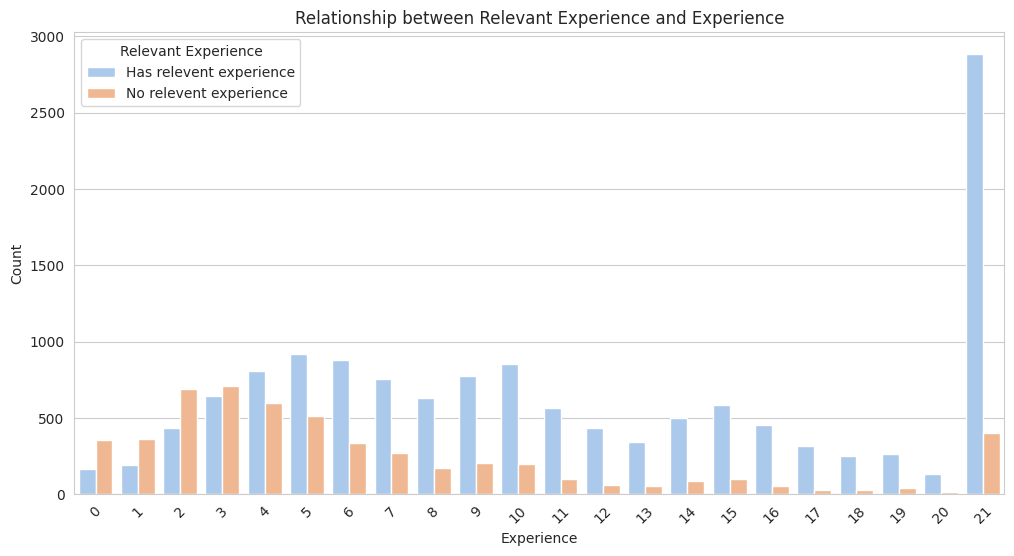

In [242]:
plt.figure(figsize=(12, 6))
sns.countplot(x='experience', hue='relevant_experience', data=df, order=sorted(df['experience'].unique()))
plt.xlabel('Experience')
plt.ylabel('Count')
plt.title('Relationship between Relevant Experience and Experience')
plt.legend(title='Relevant Experience')
plt.xticks(rotation=45)
plt.show()

plt.show()

I am aware that the data is imputed, but still it would have been obvious that the more experience a person has, the more likely they are to have relevant experience.
The count of people with no relevant experience outnumbers the count of people with relevant experience intil the 4 years of experience mark.

Next, I'll one-hot encoding to convert the relevant_experience column to numerical type.

In [243]:
df = pd.get_dummies(df, columns=['relevant_experience'], drop_first=True)
df_test = pd.get_dummies(df_test, columns=['relevant_experience'], drop_first=True)

rel_experience_map = {'relevant_experience_Has relevent experience': 'relevant_experience_yes', 'relevant_experience_No relevent experience': 'relevant_experience_no'}
df.rename(columns=rel_experience_map, inplace=True)
df_test.rename(columns=rel_experience_map, inplace=True)

df.head()

,city_id,city_development_index,gender,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target,relevant_experience_no
0,103,0.920,1,no_enrollment,Graduate,STEM,21,NaN,NaN,1,36,1.0,False
1,40,0.776,1,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0,True
2,21,0.624,3,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0,True
3,115,0.789,3,NaN,Graduate,Business Degree,0,NaN,Pvt Ltd,never,52,1.0,True
4,162,0.767,1,no_enrollment,Masters,STEM,21,50-99,Funded Startup,4,8,0.0,False


In [244]:
exp_outliers = outliers(df, 'experience')
print('Number of outliers: ', len(exp_outliers))

Number of outliers:  0


### Education features

In [245]:
df['enrolled_university'].value_counts(normalize=True)

enrolled_university
no_enrollment       0.736043
Full time course    0.200139
Part time course    0.063818
Name: proportion, dtype: float64

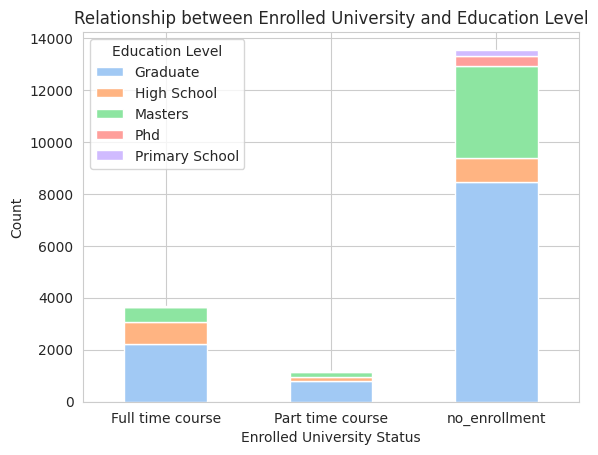

In [246]:
crosstab = pd.crosstab(df['enrolled_university'], df['education_level'])

crosstab.plot(kind='bar', stacked=True)
plt.xlabel('Enrolled University Status')
plt.ylabel('Count')
plt.title('Relationship between Enrolled University and Education Level')
plt.legend(title='Education Level')
plt.xticks(rotation=0)
plt.show()

Around 73% of respondents are not enrolled in any university, and most candidates have a Bachelor's degree.

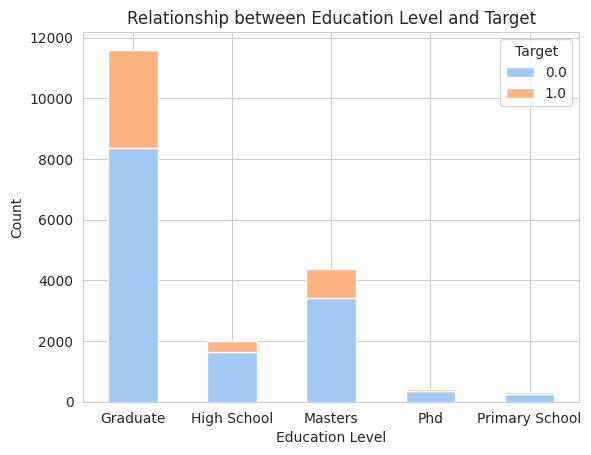

In [247]:
crosstab = pd.crosstab(df['education_level'], df['target'])

crosstab.plot(kind='bar', stacked=True)
plt.xlabel('Education Level')
plt.ylabel('Count')
plt.title('Relationship between Education Level and Target')
plt.legend(title='Target')
plt.xticks(rotation=0)
plt.show()

Furthermore, based on percentages, gradutes are a bit more likely to look for a job change, unlike people with no formal education or PhD. 
Even so, most of graduates are not looking for a job change, as do most candidates in the dataset.

In [248]:
ratios = df.groupby('education_level')['target'].sum() / df.groupby('education_level')['target'].count()
print('Ratio of people looking for job change per education level:')
print(ratios.sort_values(ascending=False))

Ratio of people looking for job change per education level:
education_level
Graduate          0.279790
Masters           0.214400
High School       0.195340
Phd               0.140097
Primary School    0.133117
Name: target, dtype: float64


Goign back to missing values, since the number of missing values for these columns are quite high, I will impute them using KNNImputer.

In [249]:
df['education_level'].fillna('Unknown', inplace=True)
df_test['education_level'].fillna('Unknown', inplace=True)

df['enrolled_university'].fillna('Unknown', inplace=True)
df_test['enrolled_university'].fillna('Unknown', inplace=True)

df = pd.get_dummies(df, columns=['enrolled_university', 'education_level'], drop_first=True)
df_test = pd.get_dummies(df_test, columns=['enrolled_university', 'education_level'], drop_first=True)

df.head()

,city_id,city_development_index,gender,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target,relevant_experience_no,enrolled_university_Part time course,enrolled_university_Unknown,enrolled_university_no_enrollment,education_level_High School,education_level_Masters,education_level_Phd,education_level_Primary School,education_level_Unknown
0,103,0.920,1,STEM,21,NaN,NaN,1,36,1.0,False,False,False,True,False,False,False,False,False
1,40,0.776,1,STEM,15,50-99,Pvt Ltd,>4,47,0.0,True,False,False,True,False,False,False,False,False
2,21,0.624,3,STEM,5,NaN,NaN,never,83,0.0,True,False,False,False,False,False,False,False,False
3,115,0.789,3,Business Degree,0,NaN,Pvt Ltd,never,52,1.0,True,False,True,False,False,False,False,False,False
4,162,0.767,1,STEM,21,50-99,Funded Startup,4,8,0.0,False,False,False,True,False,True,False,False,False


In [250]:
df['major_discipline'].value_counts()

major_discipline
STEM               14492
Humanities           669
Other                381
Business Degree      327
Arts                 253
No Major             223
Name: count, dtype: int64

About 14% of the data is missing in the major_discipline column. I will fill the missing values with a new category 'Unknown'.

In [251]:
df['major_discipline'].fillna('Unknown', inplace=True)
df_test['major_discipline'].fillna('Unknown', inplace=True)

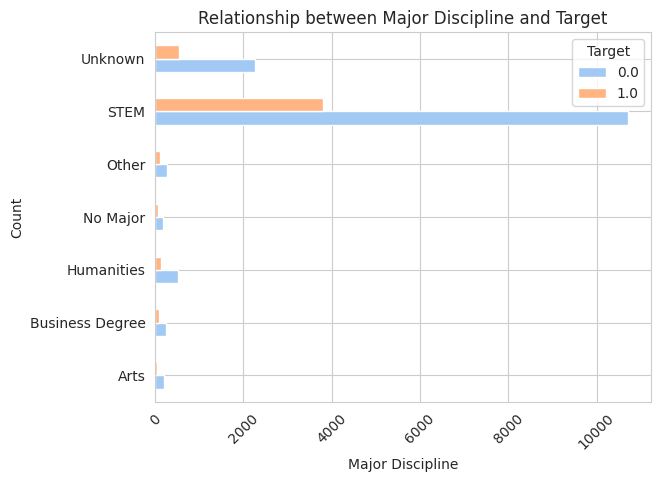

In [252]:
crosstab = pd.crosstab(df['major_discipline'], df['target'])

crosstab.plot(kind='barh')
plt.xlabel('Major Discipline')
plt.ylabel('Count')
plt.title('Relationship between Major Discipline and Target')
plt.legend(title='Target')
plt.xticks(rotation=45)
plt.show()

As expected, people with STEM majors outnumber those with non-STEM majors by far in the dataset. Among them however, the proportion of individuals who choose to stay in their company is significantly higher compared to those who are looking for a job change.

I chose to use one-hot encoding to convert the major_discipline column to numerical type.

In [253]:
df = pd.get_dummies(df, columns=['major_discipline'], prefix='major')
df_test = pd.get_dummies(df_test, columns=['major_discipline'], prefix='major')

### company_size and company_type

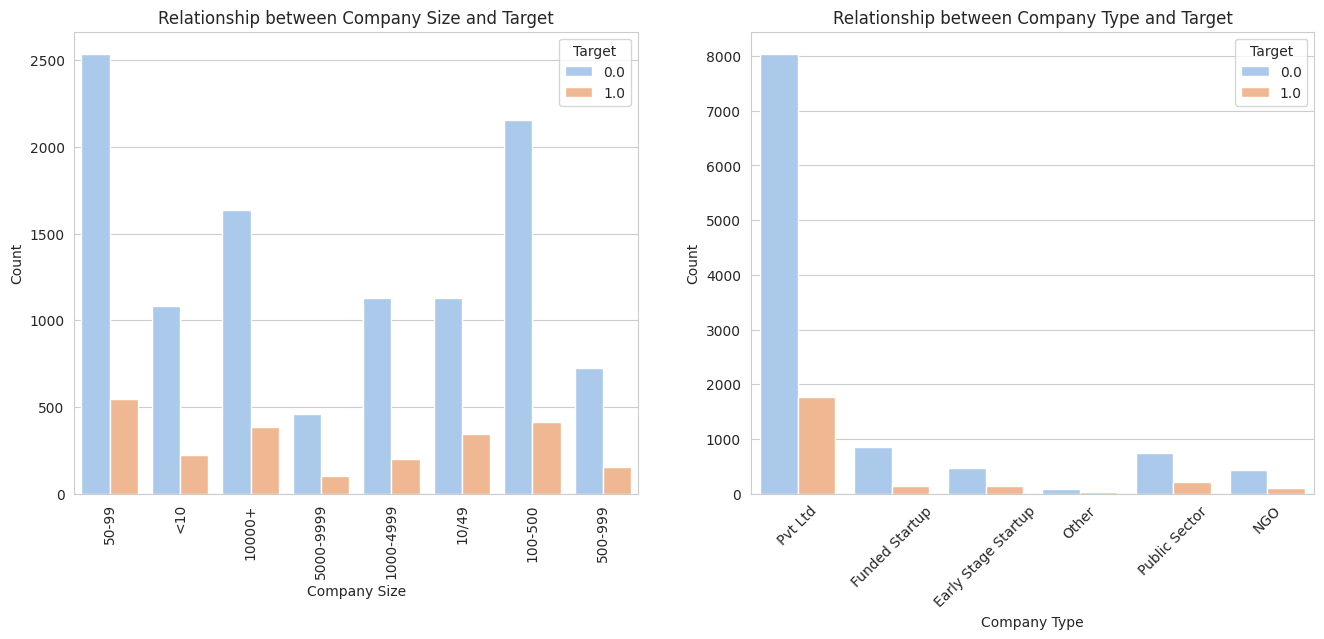

In [254]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
sns.countplot(ax=axes[0], x='company_size', hue='target', data=df)
sns.countplot(ax=axes[1], x='company_type', hue='target', data=df)
axes[0].set_xlabel('Company Size')
axes[0].set_ylabel('Count')
axes[0].set_title('Relationship between Company Size and Target')
axes[0].legend(title='Target')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90)
axes[1].set_xlabel('Company Type')
axes[1].set_ylabel('Count')
axes[1].set_title('Relationship between Company Type and Target')
axes[1].legend(title='Target')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)

plt.show()

Most of the data scientists are working in the company with size of 50-99 employees in Pvt Ltd company types.

Next I'll use one-hot encoding to convert the company_type column to numerical type.

In [255]:
df = to_numeric(df, 'company_size')
df_test = to_numeric(df_test, 'company_size')

df.dropna(subset=['company_size', 'company_type'], inplace=True)

df = pd.get_dummies(df, columns=['company_size', 'company_type'], drop_first=True)
df_test = pd.get_dummies(df_test, columns=['company_size', 'company_type'], drop_first=True)

df.head()

,city_id,city_development_index,gender,experience,last_new_job,training_hours,target,relevant_experience_no,enrolled_university_Part time course,enrolled_university_Unknown,...,company_size_3,company_size_4,company_size_5,company_size_6,company_size_7,company_type_Funded Startup,company_type_NGO,company_type_Other,company_type_Public Sector,company_type_Pvt Ltd
1,40,0.776,1,15,>4,47,0.0,True,False,False,...,False,True,False,False,False,False,False,False,False,True
3,115,0.789,3,0,never,52,1.0,True,False,True,...,False,False,False,False,False,False,False,False,False,True
4,162,0.767,1,21,4,8,0.0,False,False,False,...,False,True,False,False,False,True,False,False,False,False
6,160,0.920,1,5,1,24,0.0,False,False,False,...,False,True,False,False,False,True,False,False,False,False
7,46,0.762,1,13,>4,18,1.0,False,False,False,...,False,False,False,False,True,False,False,False,False,True


### last_new_job

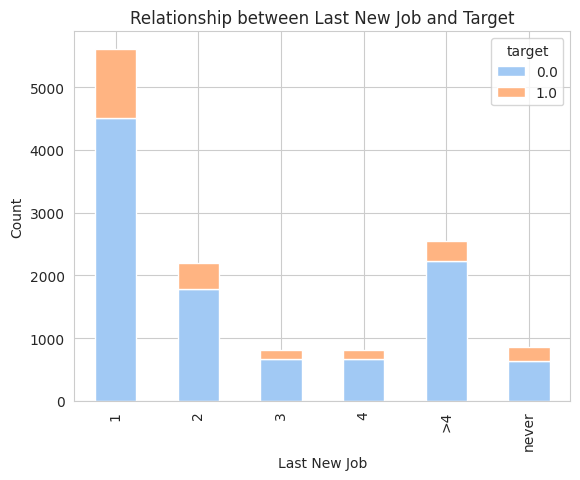

In [256]:
crosstab = pd.crosstab(df['last_new_job'], df['target'])
crosstab.plot(kind='bar', stacked=True)
plt.xlabel('Last New Job')
plt.ylabel('Count')
plt.title('Relationship between Last New Job and Target')
plt.show()

The most common gap of years between the previous and current job in the dataset is 1 year, followed by 4 years. 

I will use KNNImputer to impute the missing values as well.

In [257]:
last_new_job_map = {'>4': 5, 'never': 0}

df['last_new_job'].replace(last_new_job_map, inplace=True)
df['last_new_job'] = imputer.fit_transform(df[['last_new_job']]).astype(int)

df_test['last_new_job'].replace(last_new_job_map, inplace=True)
df_test['last_new_job'] = imputer.transform(df_test[['last_new_job']]).astype(int)

df.head()

,city_id,city_development_index,gender,experience,last_new_job,training_hours,target,relevant_experience_no,enrolled_university_Part time course,enrolled_university_Unknown,...,company_size_3,company_size_4,company_size_5,company_size_6,company_size_7,company_type_Funded Startup,company_type_NGO,company_type_Other,company_type_Public Sector,company_type_Pvt Ltd
1,40,0.776,1,15,5,47,0.0,True,False,False,...,False,True,False,False,False,False,False,False,False,True
3,115,0.789,3,0,0,52,1.0,True,False,True,...,False,False,False,False,False,False,False,False,False,True
4,162,0.767,1,21,4,8,0.0,False,False,False,...,False,True,False,False,False,True,False,False,False,False
6,160,0.920,1,5,1,24,0.0,False,False,False,...,False,True,False,False,False,True,False,False,False,False
7,46,0.762,1,13,5,18,1.0,False,False,False,...,False,False,False,False,True,False,False,False,False,True


### training_hours

In [258]:
df['training_hours'].describe()

count    13018.000000
mean        65.505684
std         60.569065
min          1.000000
25%         23.000000
50%         47.000000
75%         89.000000
max        336.000000
Name: training_hours, dtype: float64

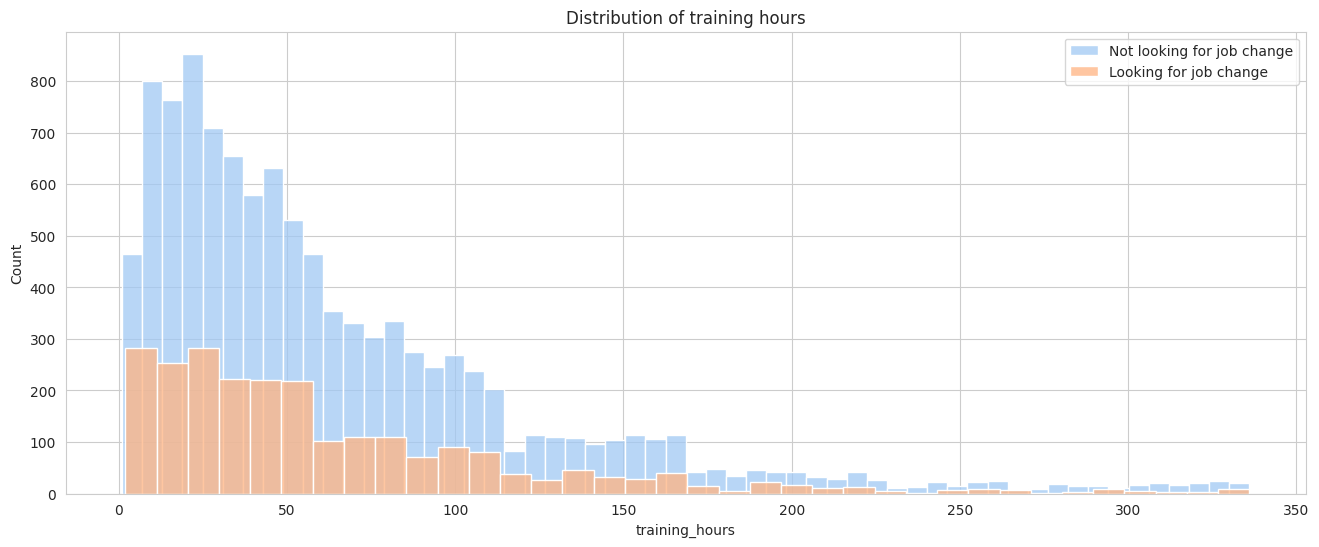

In [259]:
plt.figure(figsize=(16, 6))
sns.histplot(df[df['target']==0]['training_hours'], label='Not looking for job change')
sns.histplot(df[df['target']==1]['training_hours'], label='Looking for job change')
plt.title('Distribution of training hours')
plt.legend()
plt.show()

Most of the people who are looking for a job change have less than 100 hours of training. The peak is at around 20 hours.

Thus, we can conclude that people who are looking for a job change are not necessarily those who are actively learning the most.

Time to check outliers.

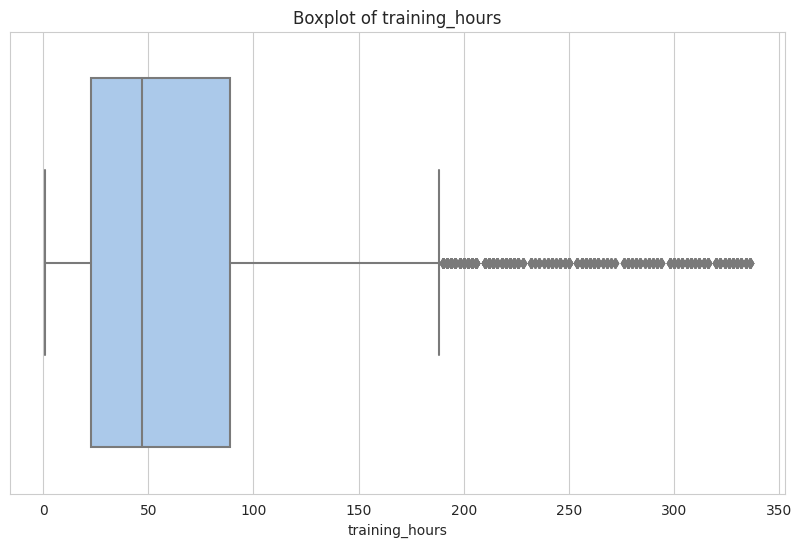

Number of outliers:  660


In [260]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['training_hours'])
plt.title('Boxplot of training_hours')
plt.show()

th_outliers = outliers(df, 'training_hours')
print('Number of outliers: ', len(th_outliers))

In [261]:
th_outliers['training_hours'].describe()

count    660.000000
mean     250.496970
std       46.292417
min      190.000000
25%      210.000000
50%      242.000000
75%      292.000000
max      336.000000
Name: training_hours, dtype: float64

There are 660 outliers in training_hours, them being values between 190 and 336 hours. Since the values seem reasonable, I will not remove them.

## 5. Target Correlation <a id='target_correlation'></a>

In [262]:
corr = df.corr()

corr['target'].abs().sort_values(ascending=False).head(10)

target                               1.000000
city_development_index               0.425898
city_id                              0.227944
experience                           0.202929
enrolled_university_no_enrollment    0.095721
last_new_job                         0.077547
gender                               0.076067
major_STEM                           0.066051
relevant_experience_no               0.053441
education_level_High School          0.053387
Name: target, dtype: float64

It seems that demographics - city_development_index, city_id - have the highest correlation with the target variable, followed by experience. Surprisingly, training_hours has one of the lowest correlations with the target variable.

## 6. Final Data Preparation <a id='data_preparation'></a>

In [263]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13018 entries, 1 to 19156
Data columns (total 36 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   city_id                               13018 non-null  int64  
 1   city_development_index                13018 non-null  float64
 2   gender                                13018 non-null  int8   
 3   experience                            13018 non-null  int64  
 4   last_new_job                          13018 non-null  int64  
 5   training_hours                        13018 non-null  int64  
 6   target                                13018 non-null  float64
 7   relevant_experience_no                13018 non-null  bool   
 8   enrolled_university_Part time course  13018 non-null  bool   
 9   enrolled_university_Unknown           13018 non-null  bool   
 10  enrolled_university_no_enrollment     13018 non-null  bool   
 11  education_level_High

After preprocessing, I will save the data to a new csv file, which will be used for model training. I'll explore feature importance in the next notebook as well.

In [264]:
df.to_csv('../data/processed/train.csv', index=False)
df_test.to_csv('../data/processed/test.csv', index=False)